## This notebook is part of self learning Quantum Computing Algorithms

## Solve TSP using QAOA 

In [1]:
# useful additional packages
import networkx as nx
import numpy as np

from qiskit import Aer
from qiskit_optimization.applications import Tsp
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo

In [2]:
# Generating a TSP instance of n cities
n = 4
num_qubits = n ** 2
ins = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_matrix(ins.graph)
print('distance\n', adj_matrix)

# Create a random TSP Hamiltonian
qp = ins.to_quadratic_program()


algorithm_globals.random_seed = 10598
quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), seed_simulator=algorithm_globals.random_seed, seed_transpiler=algorithm_globals.random_seed)
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0., 0.])
exact_mes = NumPyMinimumEigensolver()

def route_x(x):
    n = int(np.sqrt(len(x)))
    route = []
    for p__ in range(n):
        for i in range(n):
            if x[i * n + p__]:
                route.append(i)
    return route
            
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(exact_mes)
exact_result = exact.solve(qp)
print("\nExact:\n", exact_result)
print("\nRoute:\n", route_x(exact_result.x))

# solving the Problem using QAOA
qaoa = MinimumEigenOptimizer(qaoa_mes) 
qaoa_result = qaoa.solve(qp)
print("\nQAOA:\n", qaoa_result)
qaoa_result = np.asarray([int(y) for y in reversed(list(qaoa_result))])
print("\nRoute:\n", route_x(qaoa_result))

distance
 [[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]]

Exact:
 optimal function value: 236.0
optimal value: [0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
status: SUCCESS

Route:
 [1, 2, 3, 0]

QAOA:
 optimal function value: 236.0
optimal value: [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
status: SUCCESS

Route:
 [1, 2, 3, 0]


## Weight Matrix

In [3]:
"""
array([[68.23518632,  5.38210188],
       [22.03598728, 18.43718107],
       [17.59059011, 81.20945067],
       [92.3344998 , 27.65743978]])
ref: https://numpy.org/doc/stable/reference/random/generator.html
"""
coordinates = np.random.default_rng(123).uniform(low=0, high=100, size=(4, 2))

In [4]:
"""
{0: (68.23518632481435, 5.382101880222267), 1: (22.03598727726114, 18.43718106986697), 
2: (17.590590108503037, 81.20945066557736), 3: (92.33449980270564, 27.657439779710625)}
"""
pos = dict()
for i, coordinate in enumerate(coordinates):
    pos[i] = (coordinate[0], coordinate[1])

In [5]:
"""
ref: https://networkx.org/documentation/latest/reference/generated/networkx.generators.geometric.random_geometric_graph.html
"""
high = 100
low = 0
graph = nx.random_geometric_graph(n=4, radius=np.sqrt((high - low)**2 + (high - low)**2) + 1, pos=pos)

In [6]:
"""
graph.edges = EdgeView([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)])
graph.nodes = NodeView((0, 1, 2, 3))
ex: graph.nodes[0] = {'pos': (68.23518632481435, 5.382101880222267)}
rint (Round elements of the array to the nearest integer)
ref : https://numpy.org/doc/stable/reference/generated/numpy.rint.html
weights or edges = sqrt((x1 - x2)**2 + (y1 -y2)**2)
ref: https://en.wikipedia.org/wiki/Euclidean_distance
"""
for w, v in graph.edges:
    delta = []
    for i in range(2):
        delta.append(graph.nodes[w]["pos"][i] - graph.nodes[v]["pos"][i])
    graph.edges[w, v]["weight"] = np.rint(np.sqrt(delta[0]**2 + delta[1]**2))

In [7]:
"""
graph.adjacency() = holds weights of the graph
ex: 0 {1: {'weight': 48.0}, 2: {'weight': 91.0}, 3: {'weight': 33.0}}

np.full((4, 4), np.nan) = 
array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]])
index = dict(zip([0, 1, 2, 3], [0, 1, 2, 3]))
"""
index = dict(zip(list(graph), range(n)))
A = np.full((n, n), np.nan)
for u, wdict in graph.adjacency():
    for v, d in wdict.items():
        A[index[u], index[v]] = d.get("weight", 1)

A[np.isnan(A)] = 0.0
A = np.asarray(A)
M = np.asmatrix(A)
print(M)

[[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]]


In [22]:
import matplotlib.pyplot as plt

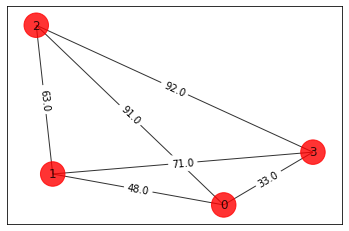

In [23]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
# Draw the graph
colors = ['r' for node in graph.nodes]
pos = [graph.nodes[node]['pos']  for node in graph.nodes]
draw_graph(graph, colors, pos)

## Quadratic Program

In [8]:
from docplex.mp.model import Model

In [9]:
mdl = Model(name="TSP")

In [11]:
x = dict()
for i in range(n):
    for j in range(n):
        x[(i, j)] = mdl.binary_var(name="x_{0}_{1}".format(i, j))
print(x)

{(0, 0): docplex.mp.Var(type=B,name='x_0_0'), (0, 1): docplex.mp.Var(type=B,name='x_0_1'), (0, 2): docplex.mp.Var(type=B,name='x_0_2'), (0, 3): docplex.mp.Var(type=B,name='x_0_3'), (1, 0): docplex.mp.Var(type=B,name='x_1_0'), (1, 1): docplex.mp.Var(type=B,name='x_1_1'), (1, 2): docplex.mp.Var(type=B,name='x_1_2'), (1, 3): docplex.mp.Var(type=B,name='x_1_3'), (2, 0): docplex.mp.Var(type=B,name='x_2_0'), (2, 1): docplex.mp.Var(type=B,name='x_2_1'), (2, 2): docplex.mp.Var(type=B,name='x_2_2'), (2, 3): docplex.mp.Var(type=B,name='x_2_3'), (3, 0): docplex.mp.Var(type=B,name='x_3_0'), (3, 1): docplex.mp.Var(type=B,name='x_3_1'), (3, 2): docplex.mp.Var(type=B,name='x_3_2'), (3, 3): docplex.mp.Var(type=B,name='x_3_3')}


## $C\left(x\right) = \sum\limits_{i=1,j = 1\\ i \ne j}^{n} w_{ij} \sum\limits_{p = 1}^{n} x_{i,p} x_{j,p+1}$

In [12]:
C_x = mdl.sum(
            M[i, j] * x[(i, k)] * x[(j, (k + 1) % n)]
            for i in range(n)
            for j in range(n)
            for k in range(n)
            if i != j
        )

In [13]:
mdl.minimize(C_x)

## $Constraints \\ \sum\limits_{i=1}^{n} x_{i,p} = 1,  \ \forall p \\ \sum\limits_{p=1}^{n} x_{i,p} = 1, \ \forall i$

In [14]:
for i in range(n):
    mdl.add_constraint(mdl.sum(x[(i, p)] for p in range(n)) == 1)
for p in range(n):
    mdl.add_constraint(mdl.sum(x[(i, p)] for i in range(n)) == 1)

In [16]:
"""
DoCPLEX to Quadratic
# Convert inequality constraints into equality constraints by adding slack variables
# Map integer variables to binary variables
# Penalize linear equality constraints with only binary variables
"""
mod = QuadraticProgram()
mod.from_docplex(mdl)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: TSP

Minimize
 obj: [ 96 x_0_0*x_1_1 + 96 x_0_0*x_1_3 + 182 x_0_0*x_2_1 + 182 x_0_0*x_2_3
      + 66 x_0_0*x_3_1 + 66 x_0_0*x_3_3 + 96 x_0_1*x_1_0 + 96 x_0_1*x_1_2
      + 182 x_0_1*x_2_0 + 182 x_0_1*x_2_2 + 66 x_0_1*x_3_0 + 66 x_0_1*x_3_2
      + 96 x_0_2*x_1_1 + 96 x_0_2*x_1_3 + 182 x_0_2*x_2_1 + 182 x_0_2*x_2_3
      + 66 x_0_2*x_3_1 + 66 x_0_2*x_3_3 + 96 x_0_3*x_1_0 + 96 x_0_3*x_1_2
      + 182 x_0_3*x_2_0 + 182 x_0_3*x_2_2 + 66 x_0_3*x_3_0 + 66 x_0_3*x_3_2
      + 126 x_1_0*x_2_1 + 126 x_1_0*x_2_3 + 142 x_1_0*x_3_1 + 142 x_1_0*x_3_3
      + 126 x_1_1*x_2_0 + 126 x_1_1*x_2_2 + 142 x_1_1*x_3_0 + 142 x_1_1*x_3_2
      + 126 x_1_2*x_2_1 + 126 x_1_2*x_2_3 + 142 x_1_2*x_3_1 + 142 x_1_2*x_3_3
      + 126 x_1_3*x_2_0 + 126 x_1_3*x_2_2 + 142 x_1_3*x_3_0 + 142 x_1_3*x_3_2
      + 184 x_2_0*x_3_1 + 184 x_2_0*x_3_3 + 184 x_2_1*x_3_0 + 184 x_2_1*x_3_2
      + 184 x_2_2*x_3_1 + 184 x_2_2*x_3_3 + 184 x_2_3*x_3_0 + 184

In [19]:
#Convert binary to integer for the paths
def route_x(x):
    n = int(np.sqrt(len(x)))
    route = []
    for p__ in range(n):
        for i in range(n):
            if x[i * n + p__]:
                route.append(i)
    return route

In [20]:
algorithm_globals.random_seed = 10598
quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), seed_simulator=algorithm_globals.random_seed, seed_transpiler=algorithm_globals.random_seed)
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0., 0.])
# solving the Problem using QAOA
qaoa = MinimumEigenOptimizer(qaoa_mes) 
qaoa_result = qaoa.solve(mod)
print("\nQAOA:\n", qaoa_result)
qaoa_result = np.asarray([int(y) for y in reversed(list(qaoa_result))])
print("\nRoute:\n", route_x(qaoa_result))


QAOA:
 optimal function value: 236.0
optimal value: [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
status: SUCCESS

Route:
 [1, 2, 3, 0]


## If you have any queries on this notebook please reach to me bala.na@hcl.com